# CZGM Garnet Multicomponent Diffusion (UWDiffusion)

This tutorial reproduces the CZGM annulus benchmark using `UWDiffusion.MulticomponentDiffusionModel`.

## What this notebook does
- loads CZGM compositional and PTt-path data
- builds an annulus-style mesh with shell boundaries
- solves Fe-Mg-Mn diffusion with implicit Ca (`1 - Σx_i`)
- updates diffusivities from the PTt path during the run
- applies shell-growth boundary updates at each growth interval
- compares final profiles with CZGM reFerence outputs

In [1]:
import os
from enum import Enum

In [2]:
import gmsh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from scipy import interpolate

In [3]:
import underworld3 as uw
from UWDiffusion import MulticomponentDiffusionModel

In [4]:
dt_fac = uw.options.getReal("dt_fac", default=10.0)
degree = uw.options.getInt("degree", default=1)
order = uw.options.getInt("order", default=1)
tolerance   = uw.options.getReal("tolerance", default=1e-6)

In [5]:
output_dir = f"./output/CZGM_comp_model_annulus_Cartesian_uwd_dt{dt_fac:g}/"
if uw.mpi.rank == 0:
    os.makedirs(output_dir, exist_ok=True)

#### Load in the CZGM exampel data

In [6]:
CZGM_EM_data = pd.read_csv("./CZGM_data/combined_array.csv", header=None)
CZGM_PTt_path = pd.read_csv("./CZGM_data/PTt_path.csv", header=None)

In [7]:
Rr, tr, Pr, Tr, Fer, Mgr, Mnr, Car = [
    np.asarray(CZGM_EM_data.iloc[:, i].to_numpy(dtype=float)) for i in range(8)
]

In [8]:
Tt_path_interp = interpolate.interp1d(CZGM_PTt_path.iloc[:, 2], CZGM_PTt_path.iloc[:, 1], fill_value="extrapolate")
Pt_path_interp = interpolate.interp1d(CZGM_PTt_path.iloc[:, 2], CZGM_PTt_path.iloc[:, 0], fill_value="extrapolate")

In [9]:
radial_growth = Rr[tr > tr.min()]           # micron
time_evolution = tr[tr > tr.min()]          # Myr
Fe_evolution = Fer[tr > tr.min()]
Mg_evolution = Mgr[tr > tr.min()]
Mn_evolution = Mnr[tr > tr.min()]
Ca_evolution = Car[tr > tr.min()]

In [10]:
u = uw.scaling.units
nd = uw.scaling.non_dimensionalise
dim = uw.scaling.dimensionalise


reFerence_diffusivity = 1e-20 * u.meter**2 / u.second
model_length = Rr.max() * u.micrometer


scaling = uw.scaling.get_coefficients()
scaling["[length]"] = model_length
scaling["[time]"] = model_length**2 / reFerence_diffusivity

In [11]:
Rr_nd = nd(Rr * u.micrometer)
time_evolution_nd = nd(time_evolution * u.megayear)

#### 1) Build annulus mesh with growth shells

Generate a circular annulus-style 2D mesh and tag shell boundaries so composition boundary conditions Can be updated during growth.

In [12]:
def build_garnet_annulus_mesh(radii_nd, mesh_degree, output_path):
    boundary_labels = ["Centre"]
    boundary_tags = [100]

    if uw.mpi.rank == 0:
        gmsh.initialize()
        gmsh.option.setNumber("General.Verbosity", False)
        gmsh.model.add("Annulus_garnet_mesh")

        def generate_curve(radius, cellsize, p0, label):
            p1 = gmsh.model.geo.add_point(radius, 0.0, 0.0, meshSize=cellsize)
            p2 = gmsh.model.geo.add_point(-radius, 0.0, 0.0, meshSize=cellsize)
            c0 = gmsh.model.geo.add_circle_arc(p1, p0, p2)
            c1 = gmsh.model.geo.add_circle_arc(p2, p0, p1)
            cl = gmsh.model.geo.add_curve_loop([c0, c1], tag=label)
            return [c0, c1], cl

        internal_curves = []
        cls = []

        cellsize = np.diff(radii_nd)[0]
        p0 = gmsh.model.geo.add_point(0.0, 0.0, 0.0, meshSize=cellsize)

        tag = 101
        final_loop = None
        for radius in radii_nd[1:]:
            internal_curve, cl = generate_curve(radius, cellsize, p0, tag)
            cls.append(cl)
            internal_curves.append(internal_curve)
            final_loop = cl
            tag += 1

        if final_loop is None:
            raise ValueError("At least two radial points are required to build annulus mesh.")

        s = gmsh.model.geo.add_plane_surface([final_loop])
        gmsh.model.geo.synchronize()

        gmsh.model.mesh.embed(0, [p0], 2, s)
        for curve in internal_curves:
            gmsh.model.mesh.embed(1, curve, 2, s)
        gmsh.model.geo.synchronize()

        gmsh.model.addPhysicalGroup(0, [p0], tag=boundary_tags[0], name=boundary_labels[0])

        shell = 0
        start_shell = Rr.shape[0] - radial_growth.shape[0] - 1
        for curve in internal_curves[start_shell:]:
            boundary_label = f"shell_{shell}"
            boundary_labels.append(boundary_label)
            boundary_tags.append(cls[shell])
            gmsh.model.addPhysicalGroup(1, curve, cls[shell], name=boundary_label)
            shell += 1

        gmsh.model.addPhysicalGroup(2, [s], 666666, "Elements")
        gmsh.model.geo.synchronize()
        gmsh.model.mesh.generate(2)
        gmsh.write(f"{output_path}/garnet_mesh.msh")
        gmsh.finalize()

    members = dict(zip(boundary_labels, boundary_tags))
    boundaries = Enum("boundaries", members)

    return uw.discretisation.Mesh(
        f"{output_path}/garnet_mesh.msh",
        degree=1,
        qdegree=mesh_degree,
        boundaries=boundaries,
        boundary_normals=None,
        coordinate_system_type=uw.coordinates.CoordinateSystemType.CARTESIAN,
        useMultipleTags=True,
        useRegions=True,
        markVertices=True,
    )

In [13]:
mesh = build_garnet_annulus_mesh(Rr_nd, degree, output_dir)

#####  2) Define multicomponent diffusion model

Set up Fe-Mg-Mn as independent components and treat Ca as implicit with a symbolic coupled diffusion matrix.

In [14]:
component_names = ["Fe", "Mg", "Mn", "Ca"]

In [15]:
D_Fe, D_Mg, D_Mn, D_Ca = sp.symbols("D_Fe D_Mg D_Mn D_Ca")
xi_1, xi_2, xi_3, xi_4 = sp.symbols("xi_1 xi_2 xi_3 xi_4")

In [16]:
D_star = [D_Fe, D_Mg, D_Mn, D_Ca]
X_star = [xi_1, xi_2, xi_3, xi_4]

In [17]:
denom = sum(D_star[k] * X_star[k] for k in range(4))

In [18]:
D_matrix_3x3 = sp.Matrix.zeros(3, 3)
for i in range(3):
    for j in range(3):
        delta_ij = 1 if i == j else 0
        term_1 = D_star[i] * delta_ij
        term_2 = (D_star[i] * X_star[i]) / denom * (D_star[j] - D_star[-1])
        D_matrix_3x3[i, j] = term_1 - term_2

In [19]:
MC_diffusion = MulticomponentDiffusionModel(
    component_names=component_names,
    mesh=mesh,
    diffusion_matrix=D_matrix_3x3,
    degree=degree,
    order=order,
)

In [20]:
Fe_var, Mg_var, Mn_var, Ca_var = MC_diffusion.mesh_vars

In [21]:
Fe_var.data[:, 0] = Fer[0]
Mg_var.data[:, 0] = Mgr[0]
Mn_var.data[:, 0] = Mnr[0]
Ca_var.data[:, 0] = 1.0 - Fe_var.data[:, 0] - Mg_var.data[:, 0] - Mn_var.data[:, 0]

#####  3) Model evolution of the garnet and diffusivities of each element

Define Arrhenius diffusivity updates, growth-step indexing, and shell boundary update logic used by the pre-solve hook.

In [22]:
def arrhenius_diffusivities_nd(temp_K, pressure_bar):
    # Chakraborty & Ganguly (1992) parameterization
    D0_Mn = 5.15e-4
    D0_Mg = 1.11e-3
    D0_Fe = 6.36e-4

    Ea_Fe, Ea_Mg, Ea_Mn = 65824, 67997, 60569
    Ev_Fe, Ev_Mg, Ev_Mn = 5.63, 5.27, 6.04

    D, Ea, Ev, R, T, P = sp.symbols("D Ea Ev R T P")
    D_expr = D * sp.exp(-(Ea + (P - 1) * Ev / 41.84) / (R * T))

    D_Fe_nd = nd(float(D_expr.subs({D: D0_Fe, Ea: Ea_Fe, Ev: Ev_Fe, R: 1.9872, T: temp_K, P: pressure_bar})) * u.centimeter**2 / u.second)
    D_Mg_nd = nd(float(D_expr.subs({D: D0_Mg, Ea: Ea_Mg, Ev: Ev_Mg, R: 1.9872, T: temp_K, P: pressure_bar})) * u.centimeter**2 / u.second)
    D_Mn_nd = nd(float(D_expr.subs({D: D0_Mn, Ea: Ea_Mn, Ev: Ev_Mn, R: 1.9872, T: temp_K, P: pressure_bar})) * u.centimeter**2 / u.second)
    D_Ca_nd = D_Mn_nd * 0.05

    return D_Fe_nd, D_Mg_nd, D_Mn_nd, D_Ca_nd

In [23]:
t_myr = dim(MC_diffusion.current_time, u.megayear).m
temp = float(Tt_path_interp(t_myr))
pressure = float(Pt_path_interp(t_myr))

DFe, DMg, DMn, DCa = arrhenius_diffusivities_nd(temp, pressure)
MC_diffusion.set_diffusion_values({
    D_Fe: DFe,
    D_Mg: DMg,
    D_Mn: DMn,
    D_Ca: DCa,
})

In [24]:
def current_growth_step(time_nd):
    idx = int(np.searchsorted(time_evolution_nd, time_nd, side="right") - 1)
    return max(0, min(idx, len(radial_growth) - 1))

In [25]:
def update_growth_domain_and_bcs(step_idx):
    r_sym = sp.sqrt(mesh.X[0] ** 2 + mesh.X[1] ** 2)
    r_vals = uw.function.evaluate(r_sym, Fe_var.coords).flatten()

    shell_radius_nd = nd(radial_growth[step_idx] * u.micrometer)
    mask_outside = r_vals > (shell_radius_nd - (0.2 * mesh.get_min_radius()))

    Fe_var.data[mask_outside, 0] = Fe_evolution[step_idx]
    Mg_var.data[mask_outside, 0] = Mg_evolution[step_idx]
    Mn_var.data[mask_outside, 0] = Mn_evolution[step_idx]
    Ca_var.data[mask_outside, 0] = Ca_evolution[step_idx]

    for solver in MC_diffusion.solvers:
        solver.essential_bcs = []

    for boundary in mesh.boundaries:
        try:
            name = boundary.name
            shell_idx = int(name.split("_")[1])
            if shell_idx >= step_idx:
                MC_diffusion.add_dirichlet_bc({name: Fe_evolution[step_idx]}, component_index=0)
                MC_diffusion.add_dirichlet_bc({name: Mg_evolution[step_idx]}, component_index=1)
                MC_diffusion.add_dirichlet_bc({name: Mn_evolution[step_idx]}, component_index=2)
        except Exception:
            pass

#####  4) Time-dependent hook and simulation phases

Register a pre-solve hook to update diffusivity from PTt conditions and advance growth boundaries through the prograde interval, then run retrograde diffusion.

In [26]:
growth_step_override = None

def pre_solve_update():
    t_myr = dim(MC_diffusion.current_time, u.megayear).m
    temp = float(Tt_path_interp(t_myr))
    pressure = float(Pt_path_interp(t_myr))

    DFe, DMg, DMn, DCa = arrhenius_diffusivities_nd(temp, pressure)
    MC_diffusion.set_diffusion_values({
        D_Fe: DFe,
        D_Mg: DMg,
        D_Mn: DMn,
        D_Ca: DCa,
    })

    if growth_step_override is None:
        step_idx = current_growth_step(MC_diffusion.current_time)
    else:
        step_idx = int(growth_step_override)

    update_growth_domain_and_bcs(step_idx)

In [27]:
MC_diffusion.register_pre_solve_hook("dynamic_physics", pre_solve_update)

In [29]:
for _solver in MC_diffusion.solvers:
    _solver.petsc_options["snes_rtol"]   = tolerance*1e-4
    _solver.petsc_options["snes_atol"]   = tolerance
    _solver.petsc_options["ksp_atol"]    = tolerance
    _solver.petsc_options["snes_max_it"] = 100
    _solver.petsc_options["snes_monitor_short"] = None

##### Run in two phases: (1) prograde growth then (2) retrograde diffusion

In [30]:
MC_diffusion.current_time = float(time_evolution_nd[0])
MC_diffusion.step = 0

#####  (1) prograde growth & diffusion

In [31]:
# Prograde / growth (force shell update at each growth timestamp)
for growth_idx, target_myr in enumerate(time_evolution[1:], start=1):
    growth_step_override = growth_idx
    MC_diffusion.run_simulation(
        duration=target_myr * u.megayear,
        max_dt=None,
        min_dt=None,
        time_step_factor=dt_fac,
    )

growth_step_override = None


Step 0, dt: 0.046799999999999904 megayear, Time: 1.27 megayear
  0 SNES Function norm 0.00119711
  1 SNES Function norm 2.49972e-08
  0 SNES Function norm 0.000112071
  1 SNES Function norm 1.19937e-09
  0 SNES Function norm 0.000621798
  1 SNES Function norm 1.53858e-05
  2 SNES Function norm 7.57289e-08

Step 1, dt: 0.03779999999999984 megayear, Time: 1.31 megayear
  0 SNES Function norm 0.00193127
  1 SNES Function norm 3.17693e-08
  0 SNES Function norm 0.000181221
  1 SNES Function norm 1.79178e-09
  0 SNES Function norm 0.000989806
  1 SNES Function norm 2.08756e-05
  2 SNES Function norm 7.59734e-08

Step 2, dt: 0.048500000000000196 megayear, Time: 1.35 megayear
  0 SNES Function norm 0.00189454
  1 SNES Function norm 3.3183e-08
  0 SNES Function norm 0.000178356
  1 SNES Function norm 1.85721e-09
  0 SNES Function norm 0.000947613
  1 SNES Function norm 2.25198e-05
  2 SNES Function norm 1.56899e-07

Step 3, dt: 0.05479999999999991 megayear, Time: 1.40 megayear
  0 SNES Functi

In [32]:
profile_coords = np.zeros((Rr_nd.shape[0], 2))
profile_coords[:, 0] = np.linspace(0.0, Rr_nd.max(), Rr_nd.shape[0])

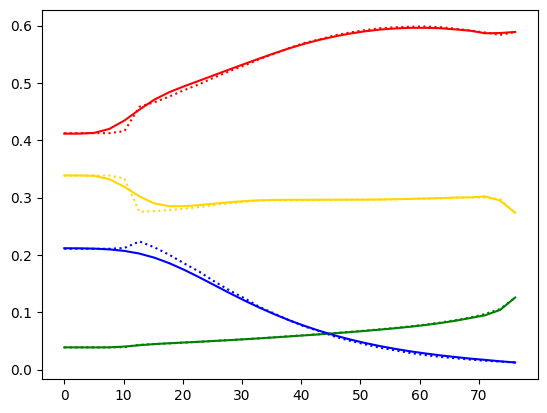

In [33]:
Fe_profile = uw.function.evaluate(Fe_var.sym[0], profile_coords).flatten()
Mg_profile = uw.function.evaluate(Mg_var.sym[0], profile_coords).flatten()
Mn_profile = uw.function.evaluate(Mn_var.sym[0], profile_coords).flatten()
Ca_profile = uw.function.evaluate(Ca_var.sym[0], profile_coords).flatten()

plt.plot(profile_coords[:, 0] * Rr.max(), Fe_profile, c="red", label="Fe")
plt.plot(profile_coords[:, 0] * Rr.max(), Mg_profile, c="green", label="Mg")
plt.plot(profile_coords[:, 0] * Rr.max(), Mn_profile, c="blue", label="Mn")
plt.plot(profile_coords[:, 0] * Rr.max(), Ca_profile, c="gold", label="Ca")

plt.plot(Rr, Fer, ls=":", c="red")
plt.plot(Rr, Mgr, ls=":", c="green")
plt.plot(Rr, Mnr, ls=":", c="blue")
plt.plot(Rr, Car, ls=":", c="gold")

#####  (2) retrograde diffusion

In [ ]:
# Retrograde (dynamic D(T,P), no forced growth step)
growth_step_override = None
MC_diffusion.run_simulation(
    duration=CZGM_PTt_path.iloc[:, 2].max() * u.megayear,
    max_dt=2 * u.megayear,
    min_dt=None # 0.1 * u.megayear,
    time_step_factor=dt_fac,
)


Step 30, dt: 0.09999999999999998 megayear, Time: 2.79 megayear
  0 SNES Function norm 0.0060104
  1 SNES Function norm 9.87508e-06
  2 SNES Function norm 1.62711e-09
  0 SNES Function norm 0.000764136
  1 SNES Function norm 3.64269e-07
  0 SNES Function norm 0.000869239
  1 SNES Function norm 1.57768e-05
  2 SNES Function norm 2.4513e-08

Step 31, dt: 0.09999999999999998 megayear, Time: 2.89 megayear
  0 SNES Function norm 0.00602677
  1 SNES Function norm 1.3541e-05
  2 SNES Function norm 3.19369e-09
  0 SNES Function norm 0.00076889
  1 SNES Function norm 4.53528e-07
  0 SNES Function norm 0.000859978
  1 SNES Function norm 1.83215e-05
  2 SNES Function norm 2.9598e-08

Step 32, dt: 0.09999999999999998 megayear, Time: 2.99 megayear
  0 SNES Function norm 0.00604755
  1 SNES Function norm 1.83676e-05
  2 SNES Function norm 6.22611e-09
  0 SNES Function norm 0.000774749
  1 SNES Function norm 5.63193e-07
  0 SNES Function norm 0.000849533
  1 SNES Function norm 2.14278e-05
  2 SNES Fu

##### 5) Results and CZGM comparison

Evaluate end-member profiles, plot against the initial profile, and compare with CZGM final composition points.

In [35]:
CZGM_EM_data_final = pd.read_csv('./CZGM_data/combined_C_final.csv', header=None)

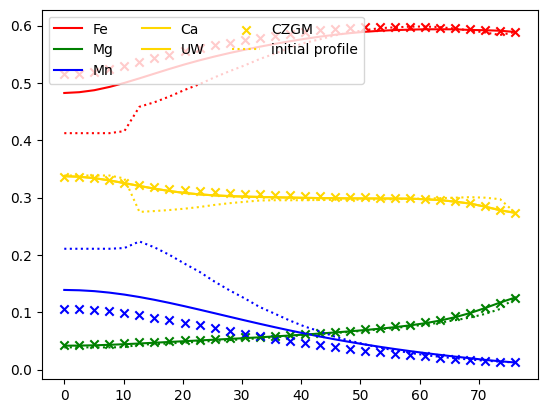

In [36]:
Fe_profile = uw.function.evaluate(Fe_var.sym[0], profile_coords).flatten()
Mg_profile = uw.function.evaluate(Mg_var.sym[0], profile_coords).flatten()
Mn_profile = uw.function.evaluate(Mn_var.sym[0], profile_coords).flatten()
Ca_profile = uw.function.evaluate(Ca_var.sym[0], profile_coords).flatten()

plt.plot(profile_coords[:, 0] * Rr.max(), Fe_profile, c="red", label="Fe")
plt.plot(profile_coords[:, 0] * Rr.max(), Mg_profile, c="green", label="Mg")
plt.plot(profile_coords[:, 0] * Rr.max(), Mn_profile, c="blue", label="Mn")
plt.plot(profile_coords[:, 0] * Rr.max(), Ca_profile, c="gold", label="Ca")

plt.plot(profile_coords[:, 0] * Rr.max(), Ca_profile, c="gold", label="UW")

plt.scatter(CZGM_EM_data_final.iloc[:,0], CZGM_EM_data_final.iloc[:,1], marker='x', c='red')
plt.scatter(CZGM_EM_data_final.iloc[:,0], CZGM_EM_data_final.iloc[:,2], marker='x', c='green')
plt.scatter(CZGM_EM_data_final.iloc[:,0], CZGM_EM_data_final.iloc[:,3], marker='x', c='blue')
plt.scatter(CZGM_EM_data_final.iloc[:,0], CZGM_EM_data_final.iloc[:,4], marker='x', c='gold', label='CZGM')


plt.plot(Rr, Fer, ls=":", c="red")
plt.plot(Rr, Mgr, ls=":", c="green")
plt.plot(Rr, Mnr, ls=":", c="blue")
plt.plot(Rr, Car, ls=":", c="gold", label='initial profile')


plt.legend(ncols=3)